<h1 style="text-align: center; vertical-align: middle;">Numerical Methods of Accelerator Physics</h1>
<h2 style="text-align: center; vertical-align: middle;">Lecture by Dr. Adrian Oeftiger</h2>

<img src="./img/etit.png" style="width: 20%; margin: auto;" />

<h3 style="text-align: center; vertical-align: middle;">Part 5: 25.11.2022</h3>

<h2>Run this notebook online!</h2>

Interact and run this jupyter notebook online:

<div class="alert alert-block alert-info" style="text-align:center;">
1. via the public mybinder.org service: <br />

<p style="text-align: center; margin-left, margin-right: auto; width: 100%;">
<a href="https://mybinder.org/v2/gh/aoeftiger/TUDa-NMAP-05/v1.0"><img src="./img/binder_logo.svg" /></a>
</p>
</div>

<div class="alert alert-block alert-success" style="text-align:center;">
2. on the <a href="https://tu-jupyter-i.ca.hrz.tu-darmstadt.de/">local TU Darmstadt jupyterhub $\nearrow$</a> (using your TU ID)

$\implies$ make sure you installed all the required python packages (see the [README](./README.md))!
</div>

Finally, also find this lecture rendered [as HTML slides on github $\nearrow$](https://aoeftiger.github.io/TUDa-NMAP-05/) along with the [source repository $\nearrow$](https://github.com/aoeftiger/TUDa-NMAP-05).

<h2>Run this first!</h2>

Imports and modules:

In [1]:
from config import (np, plt, plot_rfwave, tqdm, trange)
from scipy.constants import m_p, e, c
%matplotlib inline

If the progress bar by `tqdm` (`trange`) later in this document does not work, run this:

In [ ]:
!jupyter nbextension enable --py widgetsnbextension

<h2 style="color: #b51f2a">Refresher!</h2>

- electric field in longitudinal direction, $E_z$: only way to accelerate
- transit-time factor
- energy gain in rf cavity: synchronous particle and real particles
- synchronicity in synchrotron: beam rigidity $B\rho=p/|q|$ and $f_\text{rf}=h\cdot f_\text{rev}$
- momentum compaction $\alpha_c=\cfrac{\Delta C/C}{\delta}$, phase slippage $\eta=\cfrac{\Delta T_\text{rev}/T_\text{rev}}{\delta}$ and transition energy $\gamma_\text{t}$
- phase focusing and stability
- longitudinal tracking equations

<h2 style="color: #b51f2a">Today!</h2>

1. Monte Carlo Technique & Pseudo-random Number Generation
2. Hamiltonian for Longitudinal Dynamics
3. Initialisation of Phase Space for Longitudinal Simulations

<div style="text-align: center; width:100%;">
    <h2>Part I: Monte Carlo</h2>
</div>

<h2>Monte Carlo Technique</h2>

1. Define a domain of possible inputs and identify the <b>statistical probability distribution</b> of these inputs.
2. Generate possible inputs through <b>random sampling</b> from the probability distribution over the domain.
3. Perform <b>simulation</b> with these input parameters.
4. Collect results and <b>analyse statistically</b>.

<h2>Approach</h2>

<b>Macro-particle simulation</b>:
- represent $10^{11}..10^{13}$ particles in a bunch by smooth particle distribution function $\psi(z,\delta)$
- generate distribution of $10^5..10^7$ macro-particles by randomly sampling $\psi(z,\delta)$

<b>Approach</b>:
- uniformly distributed (pseudo-)random numbers $\xi$: Linear Congruential Generators
- construct e.g. Gaussian normal distributed random numbers: Box-Muller method
- rejection technique

<h2>Generation of Uniformly Distributed Pseudo-random Numbers</h2>

<b>Linear Congruential Generator</b>:

starting from random number seed $x_0$, generate pseudo-random sequence for integer variable $x$:

$$x_{k+1} = (a\cdot x_k + c)\quad\%\quad M$$

where parameters $(a,c)$ and $M=2^m-1$ define the generator. $x$ lies on interval $[0,M)$ and attains at most $M$ values before reaching the same value.

E.g. typical choice (Lewis, Goodman, and Miller in 1969):

$$\left\{\begin{array}\,
    M &= 2^{31}-1 = 2147483647 \\
    a &= 7^5 = 16807 \\
    c &= 0
\end{array}\right.$$

A pseudo-random number distributed uniformly on interval $[0,1)$ is then obtained via

$$\xi = \frac{x}{M}$$

In [2]:
class RandomNumberGenerator(object):
    def __init__(self, M, a, c, seed):
        self.M = M
        self.a = a
        self.c = c
        self.M = M
        self.xk = seed

    def generate(self):
        xk1 = (self.a * self.xk + self.c) % self.M
        self.xk = xk1
        return xk1 / self.M

Instantiate the linear congruential generator by Lewis et al with a certain `seed`:

In [3]:
prng_standard = RandomNumberGenerator(
    M=2**31 - 1, 
    a=7**5, 
    c=0, 
    seed=12345)

Generate a set of numbers from the sequence and analyse:

In [4]:
results = [prng_standard.generate() for i in range(10000)]

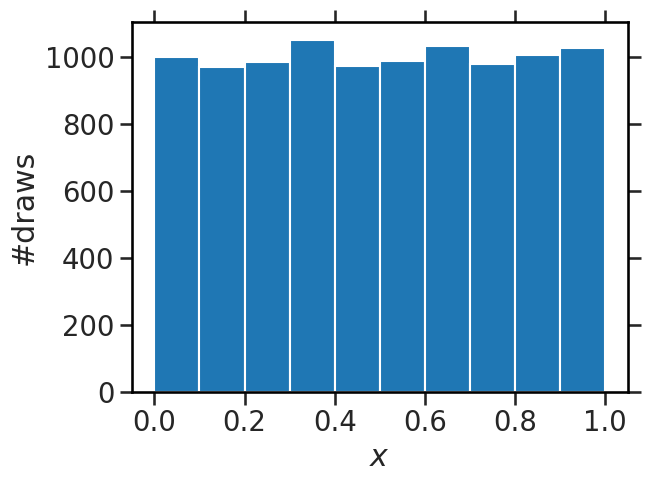

In [5]:
plt.hist(results)
plt.xlabel('$x$')
plt.ylabel('#draws');

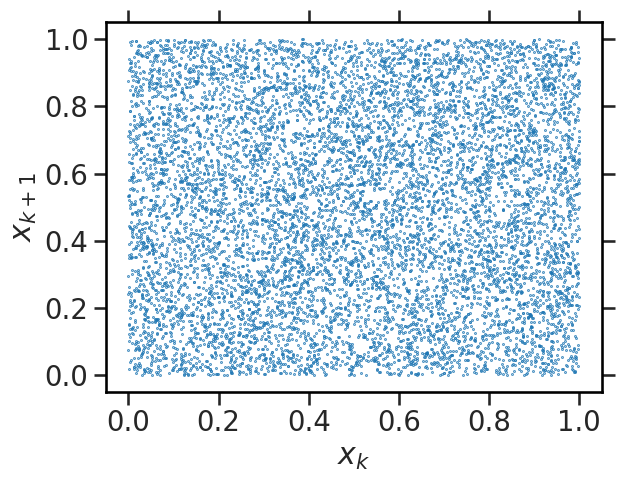

In [6]:
plt.scatter(results[:-1], results[1:], s=1, marker='.')
plt.xlabel('$x_k$')
plt.ylabel('$x_{k+1}$');

<p style="color: #e6541a;">$\implies$ what happens if you change the parameters $M,a,c$?<br /><br />
Try e.g. $a=5$ or $M=2^{31}-2$...</p>

<h2>Generation of Gaussian Normal Distributed Pseudo-random Numbers</h2>

<b>Box-Muller Method</b>: Generate $x,y$ with bi-variate Gaussian normal probability density function $f(x,y)=\frac{1}{2\pi}e^{\frac{1}{2}\left(x^2 + y^2\right)}$ from uniformly distributed random numbers $\xi_1,\xi_2\in[0,1)$,

$$\begin{align}
    x &= \sqrt{-2\ln(\xi_2)}\,\cos(2\pi\xi_1) \\
    y &= \sqrt{-2\ln(\xi_2)}\,\sin(2\pi\xi_1)
\end{align}$$

which can be derived by <b>direct inversion</b> of the cumulative distribution function of $f$.

In [7]:
prng_1 = RandomNumberGenerator(
    M=2**31 - 1, 
    a=7**5, 
    c=0, 
    seed=12345)

prng_2 = RandomNumberGenerator(
    M=2**31 - 1, 
    a=7**5, 
    c=0, 
    seed=42)

In [8]:
def generate_normal():
    xi1 = prng_1.generate()
    xi2 = prng_1.generate()
    r = np.sqrt(-2 * np.log(xi2))
    x = r * np.cos(2 * np.pi * xi1)
    y = r * np.sin(2 * np.pi * xi1)
    return x, y

In [9]:
results = np.array(
    [generate_normal() for i in range(10000)]
).flatten()

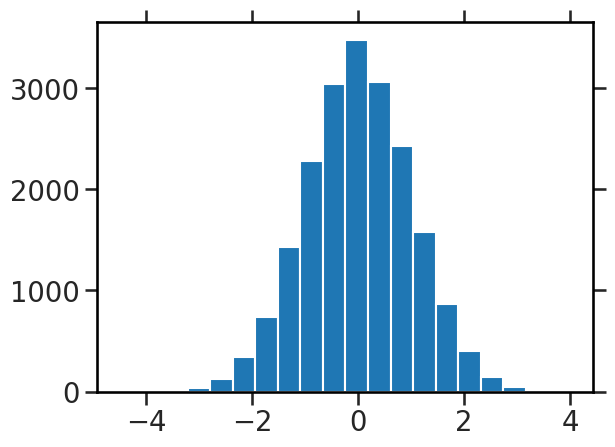

In [10]:
plt.hist(results, bins=20);

<h2>NumPy has it all...</h2>

The `numpy` library implements all of these (based on a better behaved variant of the linear congruential generator):

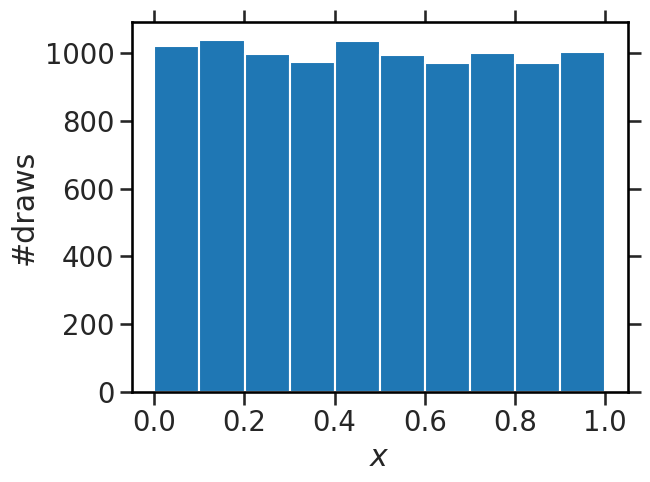

In [11]:
plt.hist(np.random.random(size=10000));
plt.xlabel('$x$')
plt.ylabel('#draws');

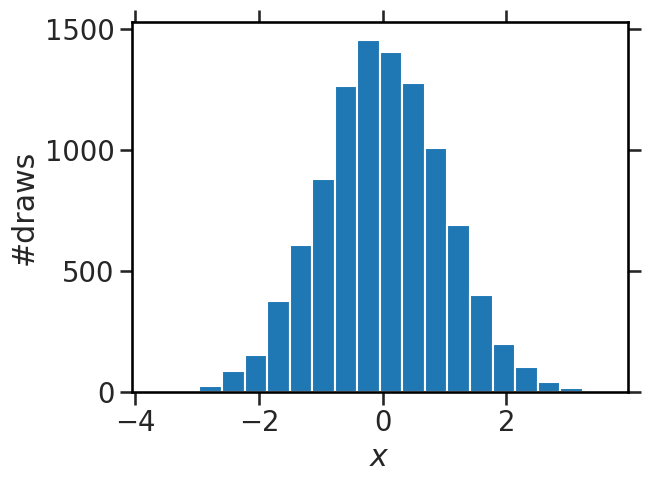

In [12]:
plt.hist(np.random.normal(size=10000), bins=20);
plt.xlabel('$x$')
plt.ylabel('#draws');

<div style="text-align: center; width:100%;">
    <h2>Part II: Hamiltonian for Longitudinal Dynamics</h2>
</div>

<h2>Longitudinal Differential Equations</h2>

Longitudinal dynamics in a synchrotron is generally called <b>synchrotron motion</b>.

From the previous lecture we recover the one-turn <b>difference map</b> for longitudinal tracking:

$$\left\{\begin{array}\,
    z_{n+1} &= z_n - \eta C \left(\cfrac{\Delta p}{p_0}\right)_n \\
    (\Delta p)_{n+1} &= (\Delta p)_n + \cfrac{q V}{(\beta c)_n}\cdot\left(\sin\left(\varphi_s - \cfrac{2\pi}{C}\cdot hz_{n+1}\right) - \sin(\varphi_s)\right)
\end{array}\right.$$

Treat <b>adiabatic acceleration</b> case ($\beta=\mathrm{const}$ during rf cavity kick) in <b>smooth focusing approximation</b> (rf cavity effect all around the ring):

$\implies$ obtain <b>differential equations</b> via $z_{n+1}-z_n\leadsto \frac{dz}{ds}\cdot C$ and $\Delta p_{n+1}-\Delta p_n \leadsto \frac{d(\Delta p)}{ds}\cdot C$

<div class="alert alert-block alert-success" style="text-align:center;">
$$\left\{\begin{array}\,
    \cfrac{dz}{ds} &= -\eta\cdot \cfrac{\Delta p}{p_0} \\
    \cfrac{d(\Delta p)}{ds} &= \cfrac{q V}{C\beta c}\cdot \left(\sin\left(\varphi_s - \cfrac{2\pi}{C}\cdot hz\right) - \sin(\varphi_s)\right)
\end{array}\right.$$
</div>

<h2>The Hamiltonian of Synchrotron Motion</h2>

To find (a sort of "instantaneous") $\mathcal{H}(z,\Delta p)=T(\Delta p) + U(z)$ which is conserved only for const. $p_0,\beta,\gamma$, integrate Hamilton equations: 

The first equation determines the kinetic energy term $T(\Delta p)$

$$\begin{align}
    \frac{dz}{ds} &\stackrel{!}{=} \frac{\partial \mathcal{H}}{\partial (\Delta p)} \\
    \stackrel{\int}{\implies} \mathcal{H}(z,\Delta p) &= \underbrace{-\frac{1}{2}\frac{\eta}{p_0} \Delta p{}^2}\limits_{T} + U(z) + \mathrm{const.}
\end{align}$$

and the second equation 

$$\frac{d(\Delta p)}{ds} \stackrel{!}{=} -\frac{\partial\mathcal{H}}{\partial z}$$

determines the potential energy $U(z)$, such that the integration gives

<div class="alert alert-block alert-success" style="text-align:center;">
    the Hamiltonian of <b>synchrotron motion</b>:<br /><br />
$$
    \mathcal{H}(z,\Delta p)=-\frac{1}{2}\frac{\eta}{p_0} \Delta p{}^2 - \frac{qV}{\beta c}\cdot\frac{1}{2\pi h}\left(\cos\left(\varphi_s - \frac{2\pi h}{C}\cdot z\right) - \frac{2\pi h}{C}\cdot z\cdot \sin(\varphi_s)\right)
+\mathrm{const.}$$
</div>

<h2>Stationary Case and Small-amplitude Approximation</h2>

For the stationary case $\sin(\varphi_s)=0$, we recover the <b>simple pendulum</b> Hamiltonian if $\varphi_s=0$ below or $\varphi_s=\pi$ above transition,

$$\mathcal{H}_\mathrm{stat}(z,\Delta p) = -\frac{1}{2}\frac{\eta}{p_0} {\color{red}{\Delta p{}^2}} +\frac{qV}{\beta c}\cdot\frac{1}{2\pi h}{\color{red}{\cos\left(\varphi_s - \frac{2\pi h}{C}\cdot z\right)}}
$$

Remember, this expresses again the phase focusing requirement!

For small $z$ around the synchronous particle (stable fixed point!), develop $\cos(x)\approx x^2/2 + \mathcal{O}(x^4)$:

$$\mathcal{H}_\mathrm{stat,small}(z,\Delta p) = -\mathrm{sgn}(\eta)\cdot\left[\frac{1}{2}\frac{|\eta|}{p_0} {\color{red}{\Delta p{}^2}} + \frac{qV}{\beta c}\cdot \cfrac{\pi h}{C^2}\cdot {\color{red}{z^2}}\right]
$$

$\implies$ Hamiltonian of harmonic oscillation!

<h2>Synchrotron Tune</h2>

The small-amplitude case (small $z$) yields the linear oscillation frequency of the particles. Assemble the 2nd-order ODE from the two 1st-order coupled ODEs:
    
$$\frac{dz^2}{ds^2}+\frac{\eta q V}{p_0 \beta c C}\cdot \left(\underbrace{\sin\left(\varphi_s - \frac{2\pi}{C} h z\right)}\limits_{\mathop{=}\sin(\varphi_s)\cos\left(\frac{2\pi}{C}hz\right) - \cos(\varphi_s)\sin\left(\frac{2\pi}{C}hz\right)} - \sin(\varphi_s)\right) = 0$$

Linearising in $z$ gives

$$\sin\left(\varphi_s - \frac{2\pi}{C} h z\right) \approx \sin(\varphi_s) - \cos(\varphi_s)\cdot\frac{2\pi}{C} h z + \mathcal{O}(z^2)$$

and therefore the linearised ODE of 2nd order (harmonic oscillator ODE) reads

$$\frac{dz^2}{ds^2}+\underbrace{\frac{\eta q V 2\pi h \cos(\varphi_s)}{p_0 \beta c C^2}}\limits_{\mathop{=}\Omega_s^2}\cdot z = 0$$

<div class="alert alert-block alert-success" style="text-align:center;">
and the <b>linear synchrotron tune</b> $Q_s$ (longitudinal oscillations per turn) evaluates to <br /><br />
$$Q_s^2=\frac{\omega_s^2}{\omega_\mathrm{rev}{}^2} = \frac{\Omega_s^2}{(2\pi/C)^2} = \frac{\eta h q V \cos(\varphi_s)}{2\pi p_0 \beta c}$$
</div>

<h2>Visualisation by Tracking in CERN PS</h2>

We return to the material from the previous lecture, the CERN Proton Synchrotron (PS):
- has a circumference of 2π·100m
- takes protons from the PS Booster at a kinetic energy of 2GeV corresponding to a γ of 3.13
- injects with 50kV of rf voltage, up to 200kV for ramp
- runs at harmonic $h=7$
- has a momentum compaction factor of $\alpha_c=0.027$
- typical acceleration rate of (up to) $\dot{B}=2$ T/s, the bending radius is $\rho=70.08$ m

In [13]:
def beta(gamma):
    '''Speed β in units of c from relativistic Lorentz factor γ.'''
    return np.sqrt(1 - gamma**-2)

def gamma(p):
    '''Relativistic Lorentz factor γ from total momentum p.'''
    return np.sqrt(1 + (p / (mass * c))**2)

Again, the `Machine` class representing the PS:

In [14]:
charge = e
mass = m_p

class Machine(object):
    gamma_ref = 3.13
    circumference = 2 * np.pi * 100
    voltage = 200e3
    harmonic = 7
    alpha_c = 0.027
    phi_s = 0.456
    
    def __init__(self, gamma_ref=gamma_ref, circumference=circumference,
                 voltage=voltage, harmonic=harmonic, 
                 alpha_c=alpha_c, phi_s=phi_s):
        '''Override default settings by giving explicit arguments.'''
        self.gamma_ref = gamma_ref
        self.circumference = circumference
        self.voltage = voltage
        self.harmonic = harmonic
        self.alpha_c = alpha_c
        self.phi_s = phi_s
    
    def eta(self, deltap):
        '''Phase-slip factor for a particle.'''
        p = self.p0() + deltap
        return self.alpha_c - gamma(p)**-2

    def p0(self):
        '''Momentum of synchronous particle.'''
        return self.gamma_ref * beta(self.gamma_ref) * mass * c

    def update_gamma_ref(self):
        '''Advance the energy of the synchronous particle
        according to the synchronous phase by one turn.
        '''
        deltap_per_turn = charge * self.voltage / (
            beta(self.gamma_ref) * c) * np.sin(self.phi_s)
        new_p0 = self.p0() + deltap_per_turn
        self.gamma_ref = gamma(new_p0)

In [15]:
def track_one_turn(z_n, deltap_n, machine):
    m = machine
    # half drift
    z_nhalf = z_n - m.eta(deltap_n) * deltap_n / m.p0() * m.circumference / 2
    # rf kick
    amplitude = charge * m.voltage / (beta(gamma(m.p0())) * c)
    phi = m.phi_s - m.harmonic * 2 * np.pi * z_nhalf / m.circumference
    
    m.update_gamma_ref()
    deltap_n1 = deltap_n + amplitude * (np.sin(phi) - np.sin(m.phi_s))
    # half drift
    z_n1 = z_nhalf - m.eta(deltap_n1) * deltap_n1 / m.p0() * m.circumference / 2
    return z_n1, deltap_n1

You can override the default PS parameters by supplying arguments to the `Machine(...)` instantiation, e.g. change the `gamma_ref` by `m = Machine(gamma_ref=20)` or the `phi_s` etc.

In [16]:
m = Machine()

Now we define the kinetic and potential energy terms and the Hamiltonian function(al) itself:

In [17]:
def T(deltap, machine):
    '''Kinetic energy term in Hamiltonian.'''
    return -0.5 * machine.eta(deltap) / machine.p0() * deltap**2

def U(z, machine, beta_=None):
    '''Potential energy term in Hamiltonian.
    If beta is not given, compute it from synchronous particle.
    '''
    m = machine
    if beta_ is None:
        beta_ = beta(gamma(m.p0()))
    ampl = charge * m.voltage / (beta_ * c * 2 * np.pi * m.harmonic)
    phi = m.phi_s - 2 * np.pi * m.harmonic / m.circumference * z
    # convenience: define z at unstable fixed point
    z_ufp = -m.circumference * (np.pi - 2 * m.phi_s) / (2 * np.pi * m.harmonic)
    # convenience: offset by potential value at unstable fixed point
    # such that unstable fixed point (and separatrix) have 0 potential energy
    return ampl * (-np.cos(phi) + 
                   2 * np.pi * m.harmonic / m.circumference * (z - z_ufp) * np.sin(m.phi_s) +
                   -np.cos(m.phi_s))

In [18]:
def hamiltonian(z, deltap, machine):
    return T(deltap, machine) + U(z, machine, beta_=beta(gamma(machine.p0() + deltap)))

In [19]:
def plot_hamiltonian(machine, zleft=-50, zright=50, dpmax=0.01, cbar=True):
    '''Plot Hamiltonian contours across (zleft, zright) and (-dpmax, dpmax).'''
    Z, DP = np.meshgrid(np.linspace(zleft, zright, num=1000), 
                        np.linspace(-dpmax, dpmax, num=1000))
    H = hamiltonian(Z, DP * machine.p0(), machine) / machine.p0()
    
    plt.contourf(Z, DP, H, cmap=plt.get_cmap('hot_r'), levels=12,
                 zorder=0, alpha=0.5)
    plt.xlabel('$z$ [m]')
    plt.ylabel(r'$\delta$')
    if cbar:
        colorbar = plt.colorbar(label=r'$\mathcal{H}(z,\Delta p)\,/\,p_0$')
        colorbar.ax.axhline(0, lw=2, c='b')
    plt.contour(Z, DP, H, colors='b', linewidths=2, levels=[0])

Let's plot the Hamiltonian landscape on phase space:

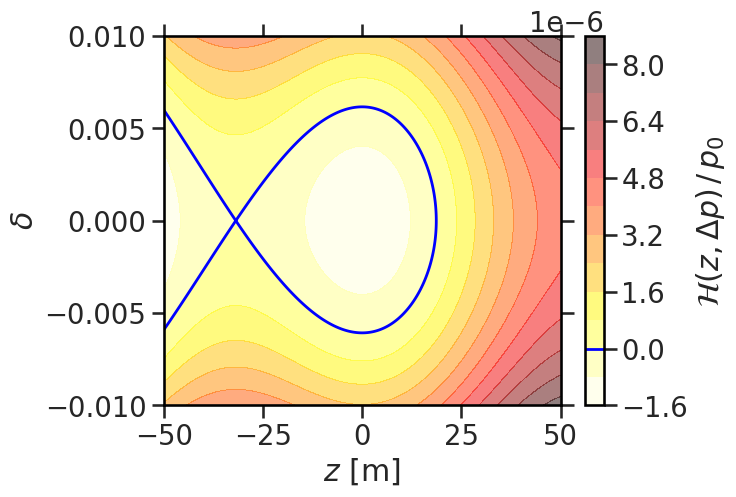

In [20]:
plot_hamiltonian(m)

Tracking just like last lecture:

In [ ]:
n_turns = 500
deltap_ini = np.linspace(0, 0.01 * m.p0(), 20)
z_ini = np.zeros_like(deltap_ini)

N = len(z_ini)
assert (N == len(deltap_ini))

In [ ]:
z = np.zeros((n_turns, N), dtype=np.float64)
deltap = np.zeros_like(z)

z[0] = z_ini
deltap[0] = deltap_ini

Record the evolution of energy $\gamma_\mathrm{ref}$ and also Hamiltonian values of particles during tracking:

In [ ]:
gammas = np.zeros(n_turns, dtype=np.float64)
gammas[0] = m.gamma_ref

H_values = np.zeros_like(z)
H_values[0] = hamiltonian(z_ini, deltap_ini, m) / m.p0()

The tracking loop:

In [ ]:
for i_turn in range(1, n_turns):
    z[i_turn], deltap[i_turn] = track_one_turn(z[i_turn - 1], deltap[i_turn - 1], m)
    gammas[i_turn] = m.gamma_ref
    H_values[i_turn] = hamiltonian(z[i_turn], deltap[i_turn], m) / m.p0()

In [ ]:
plt.plot(gammas)
plt.xlabel('Turns')
plt.ylabel('$\gamma_{ref}$')

In [ ]:
plt.scatter(z, deltap / m.p0(), marker='.', s=0.5)
plt.xlabel('$z$ [m]')
plt.ylabel('$\Delta p/p_0$')
plot_hamiltonian(m, zleft=-150, zright=50, dpmax=0.017)

In [ ]:
plt.plot(H_values, c='C0');
plt.xlabel('Turns')
plt.ylabel(r'$\mathcal{H}(z,\Delta p)\,/\,p_0$')

In [21]:
def plot_rf_overview():
    z_range = np.linspace(-150, 40, num=1000)
    # z location of unstable fixed point:
    z_ufp = -m.circumference * (np.pi - 2 * m.phi_s) / (2 * np.pi * m.harmonic)

    fig, ax = plt.subplots(3, 1, figsize=(6, 10), sharex=True)

    plt.sca(ax[0])
    plt.plot(z_range, 1e-3 * m.voltage * np.sin(m.phi_s - 2 * np.pi * m.harmonic / m.circumference * z_range))
    plt.axhline(0, c='gray', lw=2)
    plt.axhline(1e-3 * m.voltage * np.sin(m.phi_s), c='purple', lw=2, ls='--')
    plt.axvline(0, c='purple', lw=2)
    plt.axvline(z_ufp, c='red', lw=2)
    plt.ylabel('rf wave $V(z)$ [kV]')

    plt.sca(ax[1])
    plt.plot(z_range, 1e6 * U(z_range, m) / m.p0())
    plt.axhline(0, c='gray', lw=2)
    plt.ylabel(r'$U(z)\,/\,p_0\cdot 10^6$')

    plt.scatter([z_ufp], [0], marker='*', c='white', edgecolor='red', zorder=10)
    plt.scatter([0], [U(0, m) / m.p0()], marker='d', c='white', edgecolor='purple', zorder=10)

    plt.sca(ax[2])
    plot_hamiltonian(m, zleft=z_range[0], zright=z_range[-1], cbar=False)
    plt.scatter([z_ufp], [0], marker='*', c='white', edgecolor='red', zorder=10)
    plt.scatter([0], [0], marker='d', c='white', edgecolor='purple')
    plt.xlabel('$z$ [m]')
    plt.ylabel('$\delta$')
    plt.subplots_adjust(hspace=0)
    
    return fig, ax

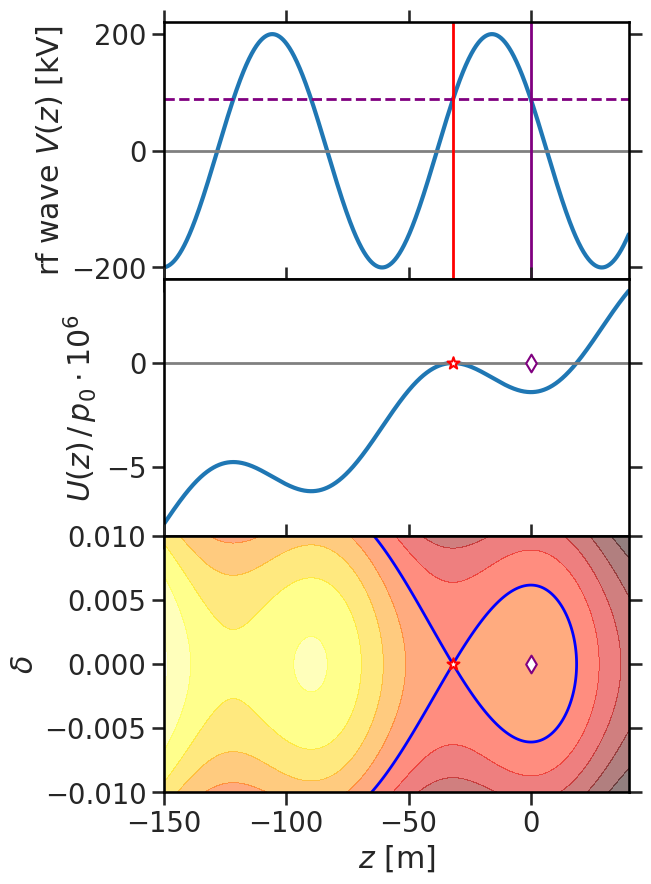

In [22]:
plot_rf_overview();

$\implies$ the closed area inside the blue separatrix is typically referred to as <b>rf bucket</b>!

<h2>Exercises based on Tracking</h2>

Modify the machine parameters and particle initial conditions to answer the following questions:

1. Do the Hamiltonian contours predict the tracked particle trajectories well?
---
2. Compare the stationary synchronous particle situation to the nonlinear pendulum: what is the meaning of the $\pi$ phase offset of $\varphi_s$ in terms of the pendulum? What state of the pendulum does the stable and what the unstable fixed point correspond to?
---
3. (if not already done last plenary session,) compute the transition energy $\gamma_\mathrm{t}$ of CERN PS
---
4. CERN PS accelerates protons from $\gamma=3.1$ up to $\gamma=27.7$. Is the transition energy crossed during acceleration? What does this mean for the setting of the synchronous phase $\varphi_s$ in the control room? 
---
5. What happens to phase focusing at the transition energy $\gamma=\gamma_\mathrm{t}$? Can you explain why? (Think of the phase slippage mechanism.)
---

$\implies$ please make sure you understand and note down the answers to these questions (as discussed during the plenary session): the concepts are central to accelerator physics and relevant for the exam.

<p style="color: #e6541a;">$\implies$ <i>"bonus": determine the synchrotron tune from tracking simulations (using NAFF) and compare to the derived formula for $Q_s$!</i></p>

<div style="text-align: center; width:100%;">
    <h2>Part III: Initialisation of Phase Space for Longitudinal Simulations</h2>
</div>

<h2>Equilibrium Distributions</h2>

Time-independent Hamiltonian system with bound states (state described by conjugate phase-space variables $q_i,p_i$ and the <b>periodic dynamics</b> by the Hamiltonian functional $\mathcal{H}=\mathcal{H}(q_i,p_i)$):

$\implies$ <b>equilibrium particle density functions</b> can be constructed in terms of the Hamiltonian $\mathcal{H}$:

$$\psi(z,\delta)=\psi(\mathcal{H})$$

"Equilibrium" $=$ no variation of $\psi$ along time parameter i.e. path length $s$

$$\frac{d\psi(\mathcal{H})}{ds} = \frac{d\psi}{d\mathcal{H}}\cdot \underbrace{\frac{d\mathcal{H}}{ds}}\limits_{\mathop{\equiv} 0}=0$$

<h2>Typical Equilibrium Distribution Functions</h2>

In particle beam dynamics one often encounters these two equilibrium distribution functions:

1. <b>thermal distribution</b>:

$$\psi(\mathcal{H}) \propto \exp\left(\cfrac{\mathcal{H}}{\mathcal{H}_0}\right)$$

2. <b>waterbag distribution</b>:

$$\psi(\mathcal{H}) \propto \Theta\left(\mathcal{H}_0-\mathcal{H}\right) = 
\left\{\begin{array}\,
    0 &,~\mathcal{H}\geq\mathcal{H}_0 \\
    1 &,~\mathcal{H}<\mathcal{H}_0
\end{array}\right.$$

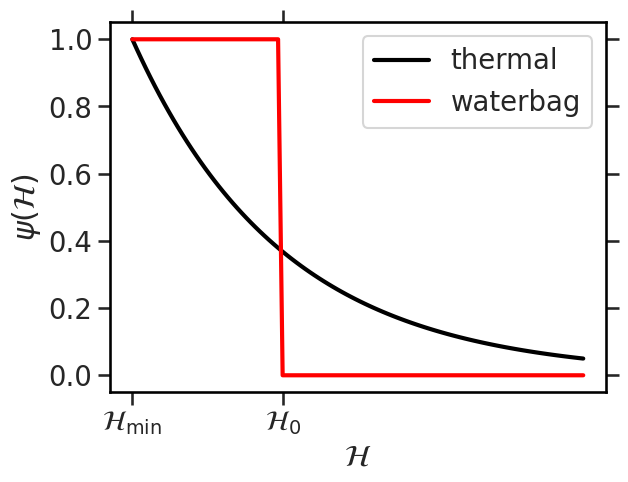

In [23]:
h = np.linspace(0, 3, 100)

plt.plot(h, np.exp(-h), c='k', label='thermal')
plt.plot(h, np.heaviside(1 - h, 0), c='r', label='waterbag')
plt.xticks([0, 1], ['$\mathcal{H}_\mathrm{min}$', '$\mathcal{H}_0$'])
plt.legend()
plt.xlabel(r'$\mathcal{H}$')
plt.ylabel(r'$\psi(\mathcal{H})$');

<h2>Equilibrium at Small Amplitudes</h2>

Let us start with the <i>small-amplitude approximation</i> and a stationary rf bucket below transition, $\varphi_s=0$: particles follow harmonic oscillation with

$$\mathcal{H}_\mathrm{stat,small}(z,\Delta p) = \frac{1}{2}\frac{-\eta}{p_0} \Delta p{}^2 + \frac{qV}{\beta c}\cdot \cfrac{\pi h}{C^2}\cdot z^2
$$

The PDF of the <i>thermal distribution</i> becomes

$$\psi(\mathcal{H})\propto\exp\left(\frac{\mathcal{H}_{stat,small}}{\mathcal{H}_0}\right)=\exp\left(\frac{1}{2}\frac{\frac{qV\,2\pi h}{\beta c C^2}}{\mathcal{H}_0}\cdot z^2\right) \cdot \exp\left(\frac{1}{2}\frac{-\eta/p_0}{\mathcal{H}_0}\cdot \Delta p^2\right)$$

which is simply a <b>bi-Gaussian distribution</b> in $\Delta p$ and $z$! The constant $\mathcal{H}_0$ is determined by a choice of the rms bunch length $\sigma_z$ (or equivalently the rms momentum deviation $\sigma_\delta=\sigma_{\Delta p}/p_0$):

$$\mathcal{H}_0 = \mathcal{H}_\mathrm{stat,small}(\sigma_z,\Delta p=0) = \frac{qV}{\beta c}\cdot \cfrac{\pi h}{C^2}\cdot \sigma_z{}^2 \color{red}{=} \mathcal{H}_\mathrm{stat,small}(z=0,\sigma_{\Delta p}) = \frac{1}{2}\frac{-\eta}{p_0} \sigma_{\Delta p}{}^2$$

$\implies$ as equilibrium condition, <b>$\sigma_z$ and $\sigma_\delta$ are linked</b> to each other via equal Hamiltonian values!

<h2>Interactive Tracking</h2>

Initialise a bi-Gaussian distribution in the longitudinal phase-space plane for tracking!

Refer once more to the CERN PS scenario, below transition and in a stationary rf bucket:

In [ ]:
m = Machine(gamma_ref=3.13, phi_s=0)

The length of the rf bucket corresponds to $C/h$:

In [ ]:
m.circumference / m.harmonic

We choose an rms bunch length of $\sigma_z=10\,$m:

In [ ]:
sigma_z = 10

The corresponding rms momentum difference $\sigma_{\Delta p}$ is given through the equilibrium condition (equal Hamiltonian values):

In [ ]:
sigma_deltap = np.sqrt(
    2 * m.p0() / -m.eta(0) * 
    charge * m.voltage * np.pi * m.harmonic / (beta(gamma(m.p0())) * c * m.circumference**2)
) * sigma_z

In [ ]:
sigma_dp = sigma_deltap / m.p0()
sigma_dp

In [ ]:
plot_hamiltonian(m)
plt.scatter([sigma_z, 0], [0, sigma_dp], marker='*', c='k')

Back to tracking, out of the box:

In [ ]:
N = 1000
n_turns = 5000

In [ ]:
np.random.seed(12345)

z_ini = np.random.normal(loc=0, scale=sigma_z, size=N)
deltap_ini = np.random.normal(loc=0, scale=sigma_deltap, size=N)

In [ ]:
z = np.zeros((n_turns, N), dtype=np.float64)
deltap = np.zeros_like(z)

z[0] = z_ini
deltap[0] = deltap_ini

In [ ]:
for i_turn in trange(1, n_turns):
    z[i_turn], deltap[i_turn] = track_one_turn(z[i_turn - 1], deltap[i_turn - 1], m)

Now let's return to the outlined Monte-Carlo approach, analysing the results in terms of statistical moments.

First the centroid:

In [ ]:
plt.plot(np.mean(z, axis=1))

plt.xlabel('Turns')
plt.ylabel(r'$\langle z \rangle$')

Then the rms beam size (bunch length):

In [ ]:
plt.plot(np.std(z, axis=1))

plt.xlabel('Turns')
plt.ylabel(r'$\sigma_z$')

<h2>What happened?</h2>

Let's look at the generated initial distribution of macro-particles:

In [ ]:
plot_hamiltonian(m);
plt.scatter(z[0], deltap[0] / m.p0(), marker='.', s=1);

$\implies$ particles have been generated outside the rf bucket! 

<h2>Rejection Sampling Method</h2>

Solution to the problem of generating particles outside the separatrix: reject them at generation!

$\leadsto$ caution: this approach modifies the effective distribution function (and the correspondingly generated effective rms values $\sigma_z, \sigma_\delta$ become smaller)! 

In [ ]:
np.random.seed(12345)

z_ini = np.random.normal(loc=0, scale=sigma_z, size=N)
deltap_ini = np.random.normal(loc=0, scale=sigma_deltap, size=N)

Hamiltonian values of particles outside separatrix are positive (below transition), $\mathcal{H}>0$ (using the full nonlinear Hamiltonian)!

Due to the discrete kicks in the finite difference maps, the Hamiltonian is only an approximation for the separatrix: better remain at a few percent distance inside of it!

In [ ]:
H_safetymargin = 0.05 * hamiltonian(0, 0, m)

H_values = hamiltonian(z_ini, deltap_ini, m) - H_safetymargin

while any(H_values >= 0):
    mask_bad = H_values >= 0
    N_bad = np.sum(mask_bad)
    print (N_bad)
    # re-initialise bad particles:
    z_ini[mask_bad] = np.random.normal(loc=0, scale=sigma_z, size=N_bad)
    deltap_ini[mask_bad] = np.random.normal(loc=0, scale=sigma_deltap, size=N_bad)
    # re-evaluate rejection condition
    H_values = hamiltonian(z_ini, deltap_ini, m) - H_safetymargin

Now we should be good to go!

In [ ]:
plot_hamiltonian(m);
plt.scatter(z_ini, deltap_ini / m.p0(), marker='.', s=1);

Tracking again...

In [ ]:
z = np.zeros((n_turns, N), dtype=np.float64)
deltap = np.zeros_like(z)

z[0] = z_ini
deltap[0] = deltap_ini

In [ ]:
for i_turn in trange(1, n_turns):
    z[i_turn], deltap[i_turn] = track_one_turn(z[i_turn - 1], deltap[i_turn - 1], m)

Looking again at the centroid:

In [ ]:
plt.plot(np.mean(z, axis=1))

plt.xlabel('Turns')
plt.ylabel(r'$\langle z \rangle$')

Then the rms bunch length:

In [ ]:
plt.plot(np.std(z, axis=1))

plt.xlabel('Turns')
plt.ylabel(r'$\sigma_z$')

<p style="color: #e6541a;">$\implies$ try larger choices of initial $\sigma_z$ and see where the bunch length evolution saturates.</p>

$\leadsto$ another problem with initialising Gaussian distributions: at larger amplitudes $z$, the small-amplitude approximation with $\mathcal{H}_\mathrm{stat,small}$ necessarily breaks down! A Gaussian particle distribution is <b>not</b> in equilibrium for sufficiently large rms values in a nonlinear potential, the particles will <b>filament</b>! (...and the rms emittance will grow, as one can observe in the final equilibrium rms bunch length which is larger than the initial $\sigma_z$!)

$\implies$ require full nonlinear Hamiltonian to construct PDF $\psi(\mathcal{H})=\exp\left(\cfrac{\mathcal{H}}{\mathcal{H}_0}\right)$

<h2>RMS Emittance</h2>

Define statistical <b>rms emittance</b> as in lecture 02:

In [ ]:
def emittance(z, deltap):
    N = len(z)
    
    # subtract centroids
    z = z - 1/N * np.sum(z)
    deltap = deltap - 1/N * np.sum(deltap)
    
    # compute Σ matrix entries
    z_sq = 1/N * np.sum(z * z)
    deltap_sq = 1/N * np.sum(deltap * deltap)
    crossterm = 1/N * np.sum(z * deltap)
    
    # determinant of Σ matrix
    epsilon = np.sqrt(z_sq * deltap_sq - crossterm * crossterm)
    return epsilon

In [ ]:
epsn_z = np.array([emittance(z_i, deltap_i) for z_i, deltap_i in zip(z, deltap)])

In [ ]:
plt.plot(epsn_z / e)
plt.xlabel('Turns')
plt.ylabel('$\epsilon_z$ [eV.s]');

<h2>Culmination: Simulate Full CERN PS Ramp</h2>

Let us <b>properly</b> simulate the full CERN PS acceleration ramp (including crossing transition) with a bunch of small phase-space area (emittance)! 

You as operator in the (simulation) control centre shall pay attention to conserve the longitudinal emittance throughout the acceleration!

In [ ]:
m = Machine()
assert m.phi_s > 0, "machine is not accelerating...?"

In [ ]:
sigma_z = 1

In [ ]:
sigma_deltap = np.sqrt(
    2 * m.p0() / -m.eta(0) * 
    charge * m.voltage * np.pi * m.harmonic / (beta(gamma(m.p0())) * c * m.circumference**2)
) * sigma_z

$(\Delta\gamma)_\mathrm{turn} = \cfrac{\Delta E_\mathrm{tot}}{m_0c^2} = \cfrac{qV\sin(\varphi_s)}{m_0c^2}$

such that accelerating from $\gamma_\mathrm{ref}=3.1$ to $\gamma_mathrm{ref}=27.7$ takes as many turns as

$n_\mathrm{turns}=\cfrac{27.7-3.1}{(\Delta\gamma)_\mathrm{turn}}$

In [ ]:
dgamma_per_turn = charge * m.voltage * np.sin(m.phi_s) / (mass * c**2)
n_turns = int((27.7-3.1) / dgamma_per_turn)
n_turns

Generate the macro-particles (small emittance, due to numerical reasons the Gaussian tails cannot reach outside the separatrix ;-) ):

In [ ]:
N = 1000

In [ ]:
np.random.seed(12345)

z = np.random.normal(loc=0, scale=sigma_z, size=N)
deltap = np.random.normal(loc=0, scale=sigma_deltap, size=N)

In [ ]:
epsn_z = np.zeros(n_turns, dtype=np.float64)

epsn_z[0] = emittance(z, deltap)

Let's go tracking! ($\approx 1\,$min)

In [ ]:
for i_turn in trange(1, n_turns):
    z, deltap = track_one_turn(z, deltap, m)
    
    epsn_z[i_turn] = emittance(z, deltap)

We have reached the extraction energy of $\gamma=27.7$:

In [ ]:
m.gamma_ref

Check that we properly conserved the rms emittance:

In [ ]:
plt.plot(np.arange(n_turns) / 100000, epsn_z / e)

plt.xlabel('Turns [100k]')
plt.ylabel('$\epsilon_z$ [eV.s]');

In [ ]:
# plot_hamiltonian(m);
# plt.scatter(z, deltap / m.p0(), marker='.', s=1);

<h2>Summary</h2>

- Linear Congruential Generators: uniformly distributed random number sequences
- Box-Muller method: Gaussian distributed random number sequences
- Synchrotron motion: difference eq. $\rightarrow$ differential eq. $\rightarrow$ Hamiltonian $\mathcal{H}$
- rf bucket: the separatrix of synchrotron motion Hamiltonian
- relationship synchronous phase $\varphi_s$ vs. phase-slip factor $\eta$ vs. phase focusing vs. tracking & Hamiltonian
- harmonic oscillator and small-amplitude approximation
- equilibrium distributions and generation of macro-particles
- thermal PDF, connection of harmonic oscillation and bi-Gaussian distributions
- rejection sampling (rf bucket)

<h2>Literature</h2>

- [J. Qiang's lecture on Monte-Carlo Simulation Techniques](https://arxiv.org/pdf/2006.10506.pdf)